In [1]:
from monai.utils import first, set_determinism
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    SaveImaged,
    ScaleIntensityRanged,
    Spacingd,
    Invertd,
    Lambdad,
    Activations,
    ScaleIntensityRange,
    Lambda,
     Resized,
    SqueezeDimd,
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet, UNETR
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob
import nrrd

print_config()

MONAI version: 1.2.0
Numpy version: 1.24.3
Pytorch version: 2.0.1+cu117
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: c33f1ba588ee00229a309000e888f9817b4f1934
MONAI __file__: /home/erattakulangara/.conda/envs/Pytorch/lib/python3.11/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: 5.3.0
Nibabel version: 5.1.0
scikit-image version: 0.20.0
Pillow version: 9.5.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.15.2+cu117
tqdm version: 4.65.0
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.5
pandas version: 2.0.1
einops version: 0.6.1
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: 1.0.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installatio

In [2]:
directory = os.environ.get("DATA_DIRECTORY")
root_dir = './Train'
save_dir = './sliceByslice'
print(root_dir)

./Train


In [3]:
train_images = sorted(
    glob.glob(os.path.join(root_dir, "RTrainVolumes", "*.nrrd")))
train_labels = sorted(
    glob.glob(os.path.join(root_dir, "RTrainLabels", "*.nrrd")))
data_dicts = [{"image": image_name, "label": label_name}
              for image_name, label_name in zip(train_images, train_labels)]
train_files, val_files = data_dicts[:-9], data_dicts[-9:]

In [4]:
import nrrd
from monai.transforms import LoadImage
set_determinism(seed=0)

out = LoadImage(reader="NrrdReader")(
    "./Train/RTrainLabels/P10a.seg.nrrd")
out[0].shape

monai.transforms.io.array LoadImage.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.


torch.Size([32, 256, 256])

In [5]:

from monai.transforms import Transposed
import numpy as np


def binarize(label, threshold=0.1):
    binary_mask = (label > threshold)
    binary_mask[binary_mask > 0] = 1  # Set all non-zero pixels to 1
    return binary_mask


train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"], reader="NrrdReader", image_only=True),
        Transposed(keys=['image', 'label'], indices=[2, 1, 0]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Lambdad(("label"), binarize),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-57,
            a_max=1000,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(
            1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        # RandCropByPosNegLabeld(
        #     keys=["image", "label"],
        #     label_key="label",
        #     spatial_size=(128, 128, 16),
        #     pos=1,
        #     neg=1,
        #     num_samples=2,
        #     image_key="image",
        #     image_threshold=0,
        # ),
        # user can also add other random transforms
        # RandAffined(
        #     keys=['image', 'label'],
        #     mode=('bilinear', 'nearest'),
        #     prob=1.0, spatial_size=(96, 96, 96),
        #     rotate_range=(0, 0, np.pi/15),
        #     scale_range=(0.1, 0.1, 0.1)),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"],
                   reader="NrrdReader", image_only=True),
        Transposed(keys=['image', 'label'], indices=[2, 1, 0]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Lambdad(("label"), binarize),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-57,
            a_max=1000,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(
            1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
    ]
)


In [6]:
import monai
check_ds = monai.data.CacheDataset(data=train_files, transform=train_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image, label = (check_data["image"], check_data["label"])
print(f"image shape: {image.shape}, label shape: {label.shape}")


Loading dataset: 100%|██████████| 39/39 [00:06<00:00,  6.46it/s]

image shape: torch.Size([1, 1, 171, 171, 16]), label shape: torch.Size([1, 1, 171, 171, 16])


In [7]:
key_set = ("image","label")
patch_func = monai.data.PatchIterd(
    keys=key_set, patch_size=(None, None, 1), start_pos=(0, 0, 0) ) # dynamic first two dimensions
          
patch_transform = Compose(
    [
        SqueezeDimd(keys=key_set, dim=-1),  # squeeze the last dim
        Resized(keys=key_set, spatial_size=[128, 128]),
        # to use crop/pad instead of resize:
        # ResizeWithPadOrCropd(keys=["img", "seg"], spatial_size=[48, 48], mode="replicate"),
    ]
)
patch_ds = monai.data.GridPatchDataset(
    data=check_ds, patch_iter=patch_func, transform=patch_transform, with_coordinates=False
)
shuffle_ds = monai.data.ShuffleBuffer(patch_ds, buffer_size=30, seed=0)
train_loader = DataLoader(
    shuffle_ds,
    batch_size=5,
    num_workers=2,
    pin_memory=torch.cuda.is_available(),
)
check_data = monai.utils.misc.first(train_loader)
print("first patch's shape: ", check_data["image"].shape, check_data["label"].shape)



first patch's shape:  torch.Size([5, 1, 128, 128]) torch.Size([5, 1, 128, 128])


image shape: torch.Size([171, 171, 16]), label shape: torch.Size([171, 171, 16])
image max: 1.0, label max : 1.0


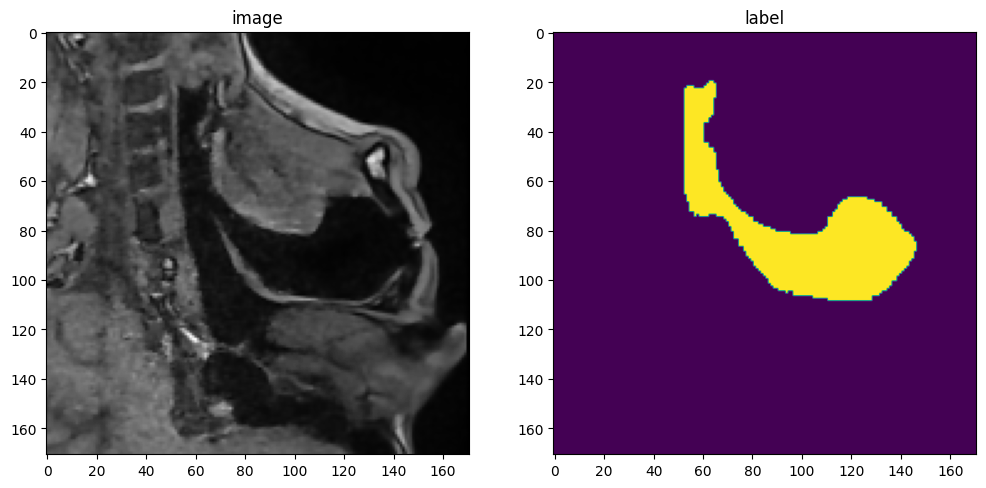

In [8]:
import numpy as np
check_ds = Dataset(data=val_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image, label = (check_data["image"][0][0], check_data["label"][0][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")
print(f"image max: {np.max(image)}, label max : {np.max(label)}")
# plot the slice [:, :, 80]
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, 10], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, 10])
plt.show()


In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda

NVIDIA A10
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [10]:
model = UNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128,256),
    strides=(2, 2, 2,2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)
loss_function = DiceLoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-3)
dice_metric = DiceMetric(include_background=False, reduction="mean")


In [11]:
max_epochs = 1200
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
post_pred = Compose([AsDiscrete(argmax=True, to_onehot=2)])
post_label = Compose([AsDiscrete(to_onehot=2)])
from monai.inferers import SliceInferer
from monai.visualize import matshow3d
val_ds = monai.data.Dataset(data=val_files, transform=val_transforms)
val_loader = DataLoader(val_ds, num_workers=1, pin_memory=torch.cuda.is_available())
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
model.eval()

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        if step % 200 == 0:
            print(f"{step}, train_loss: {loss.item():.4f}")
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_images = val_data["image"].to(device)
                roi_size = (128, 128)
                sw_batch_size = 3
                slice_inferer = SliceInferer(
                    roi_size=roi_size,
                    sw_batch_size=sw_batch_size,
                    spatial_dim=1,  # Spatial dim to slice along is defined here
                    device=torch.device("cpu"),
                    padding_mode="replicate",
                )
                val_outputs = slice_inferer(val_images, model).to("cpu")
                #dice_metric(y_pred=val_outputs > 0.5, y=val_data["label"])
                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_label(i) for i in decollate_batch(val_data["label"])]
                # compute metric for current iteration
                dice_metric(y_pred=val_outputs, y=val_data["label"])

            # aggregate the final mean dice result
            metric = dice_metric.aggregate().item()
            # reset the status for next validation round
            dice_metric.reset()

            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(save_dir, "2d_slice_best_metric_model_1200" + ".pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"
            )

----------
epoch 1/1200
epoch 1 average loss: 0.5604
----------
epoch 2/1200
epoch 2 average loss: 0.4689
saved new best metric model
current epoch: 2 current mean dice: 0.4710
best mean dice: 0.4710 at epoch: 2
----------
epoch 3/1200
epoch 3 average loss: 0.3662
----------
epoch 4/1200
epoch 4 average loss: 0.2688
saved new best metric model
current epoch: 4 current mean dice: 0.5072
best mean dice: 0.5072 at epoch: 4
----------
epoch 5/1200
epoch 5 average loss: 0.2028
----------
epoch 6/1200
epoch 6 average loss: 0.1785
saved new best metric model
current epoch: 6 current mean dice: 0.6024
best mean dice: 0.6024 at epoch: 6
----------
epoch 7/1200
epoch 7 average loss: 0.1643
----------
epoch 8/1200
epoch 8 average loss: 0.1633
saved new best metric model
current epoch: 8 current mean dice: 0.6244
best mean dice: 0.6244 at epoch: 8
----------
epoch 9/1200
epoch 9 average loss: 0.1654
----------
epoch 10/1200
epoch 10 average loss: 0.1483
current epoch: 10 current mean dice: 0.5924


In [13]:
val_outputs.shape
import matplotlib.pyplot as plt
plt.imshow(val_outputs[0][0][:,:,15])

AttributeError: 'list' object has no attribute 'shape'

In [14]:
print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")

train completed, best_metric: 0.7085 at epoch: 774


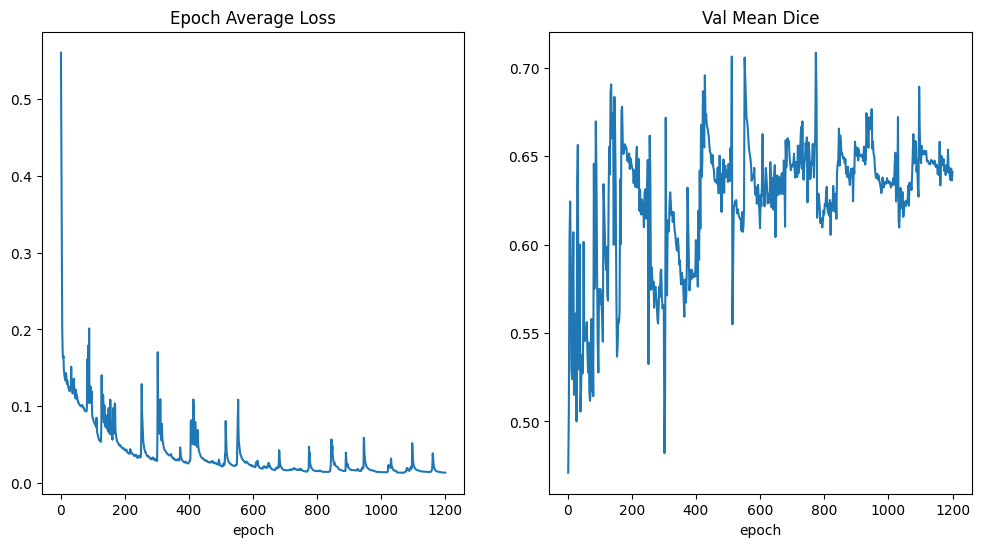

In [15]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()


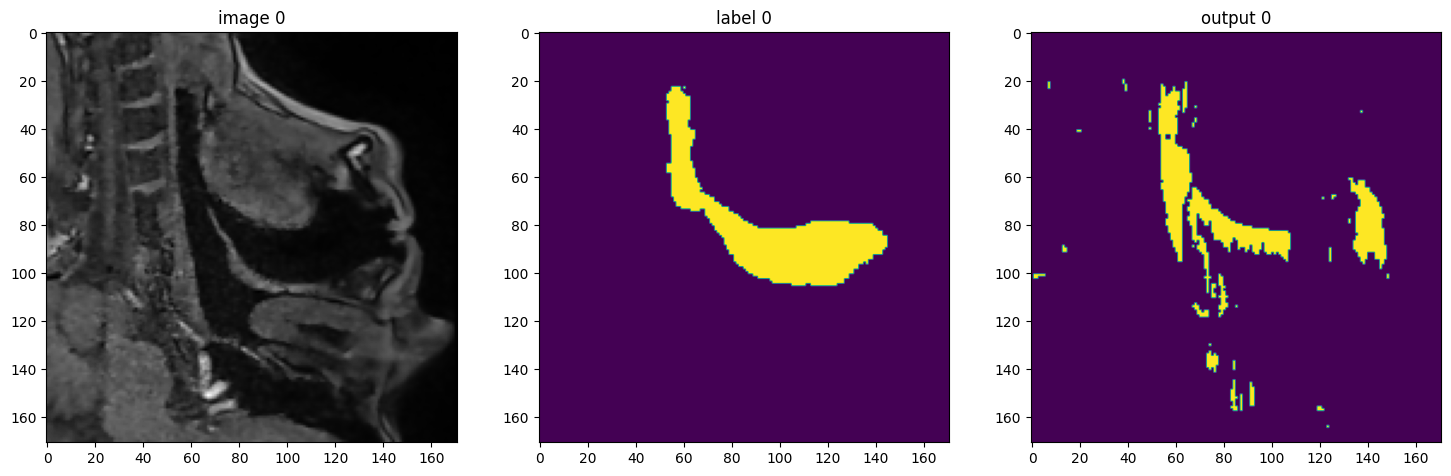

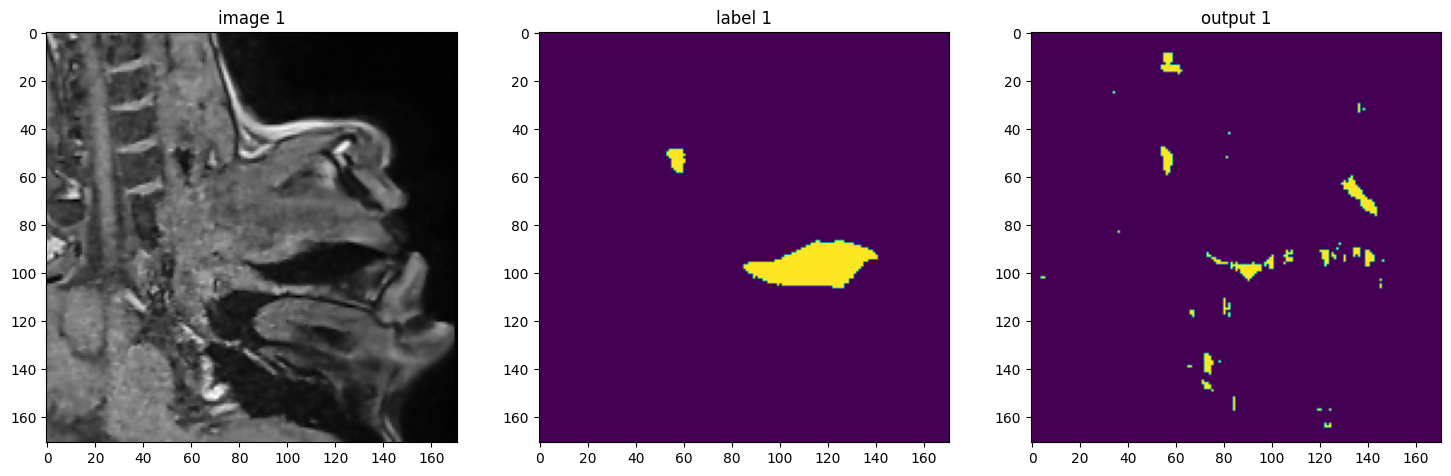

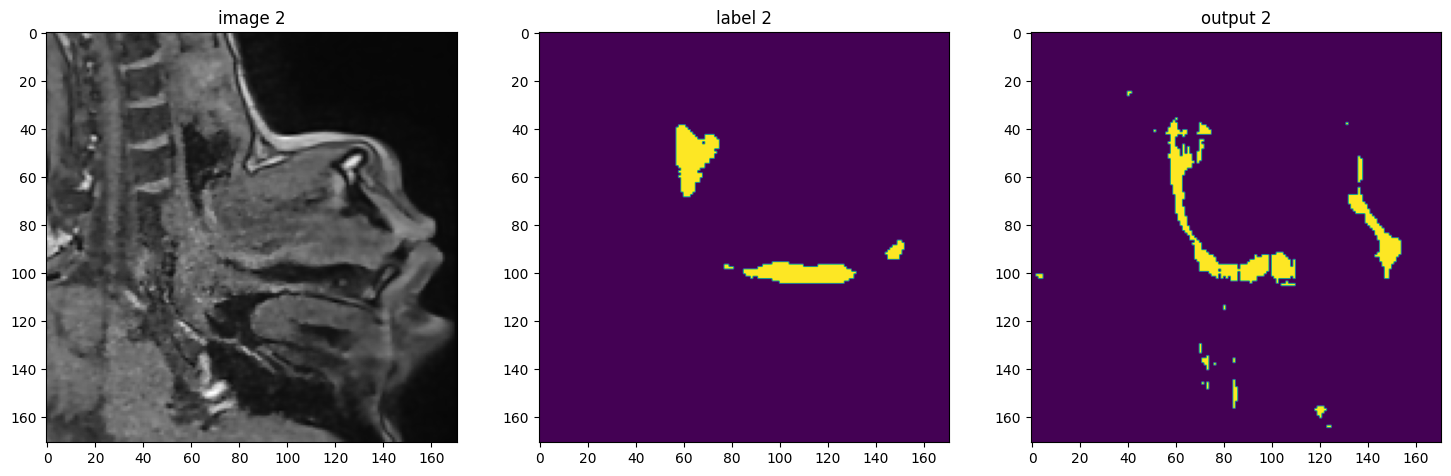

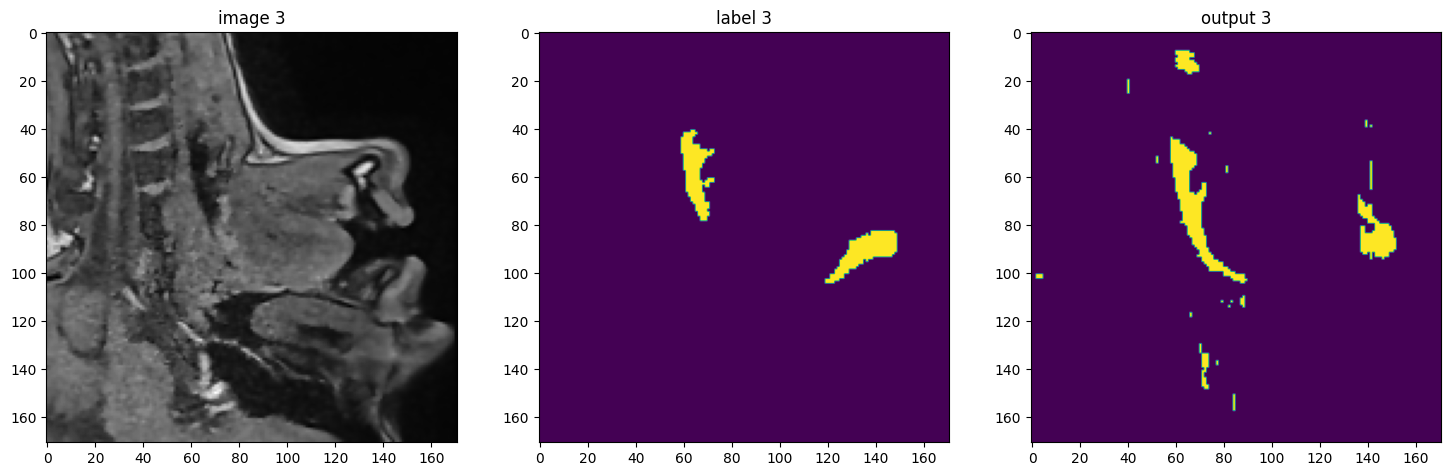

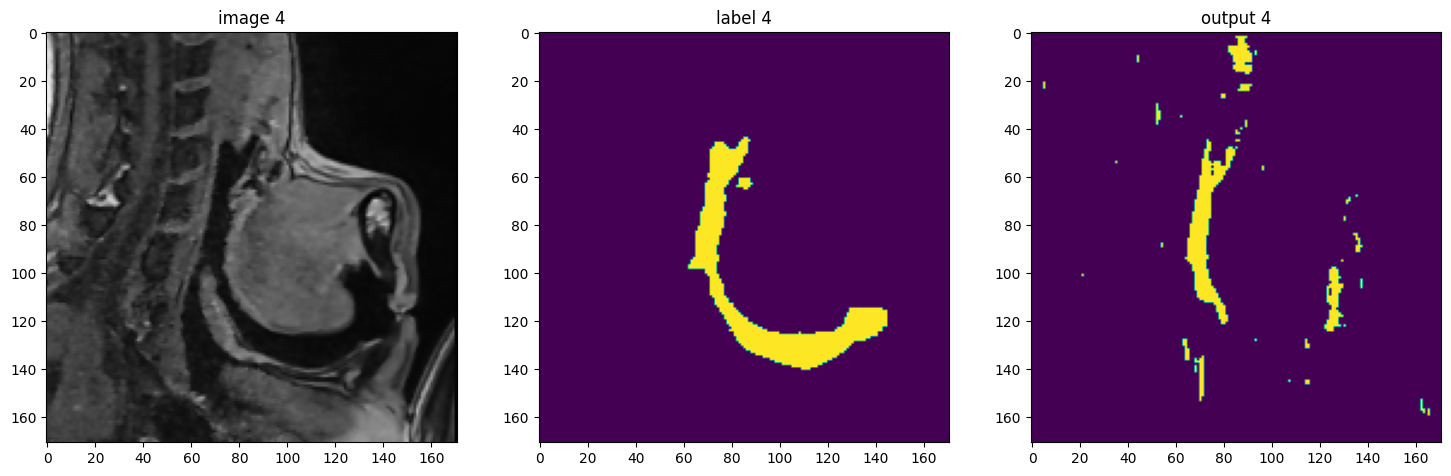

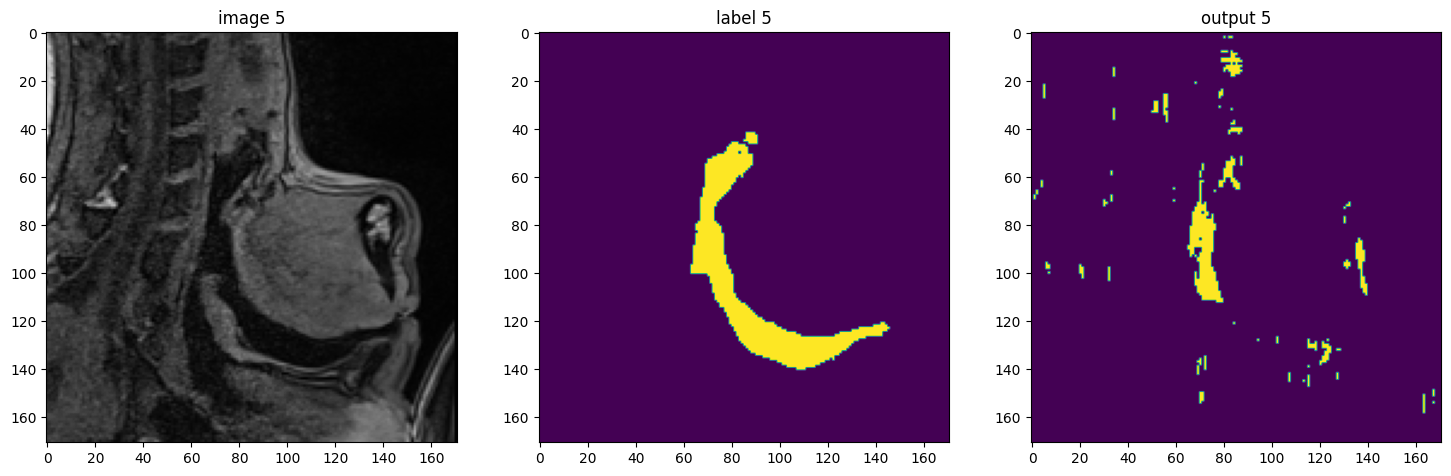

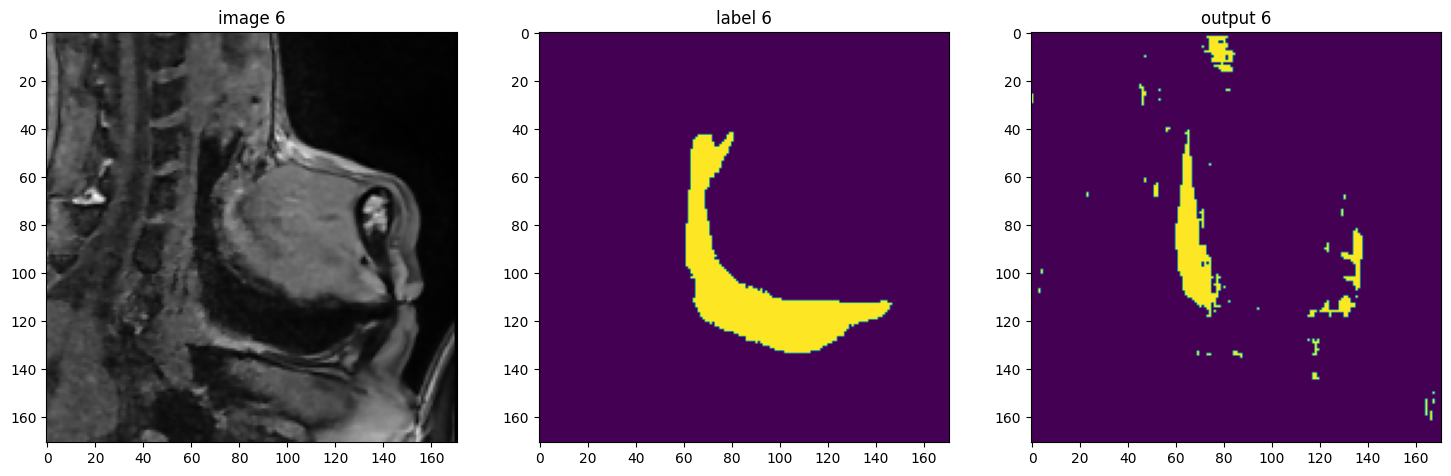

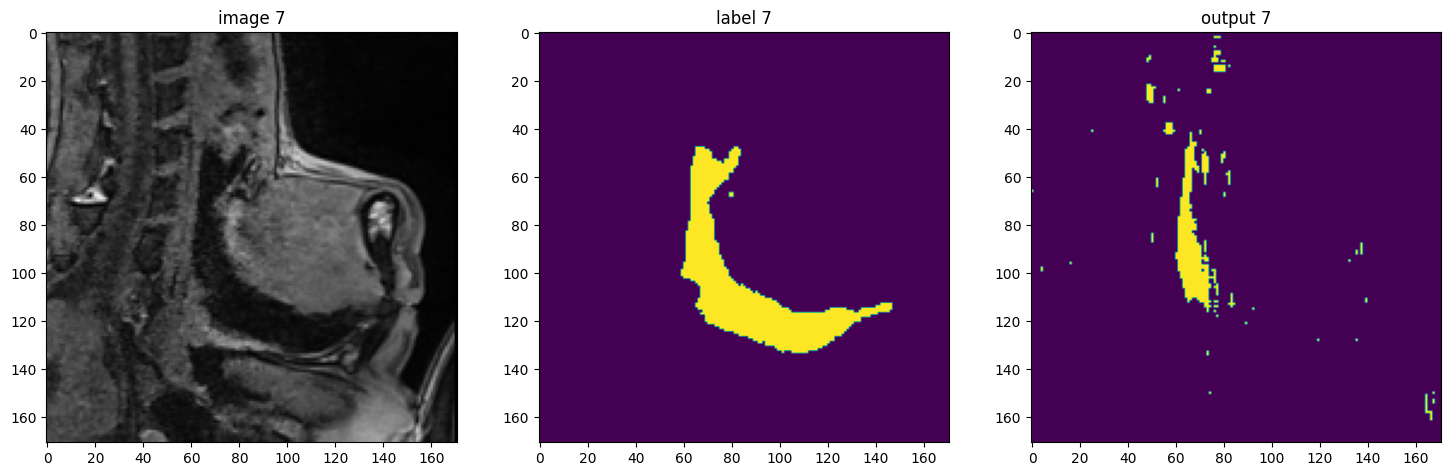

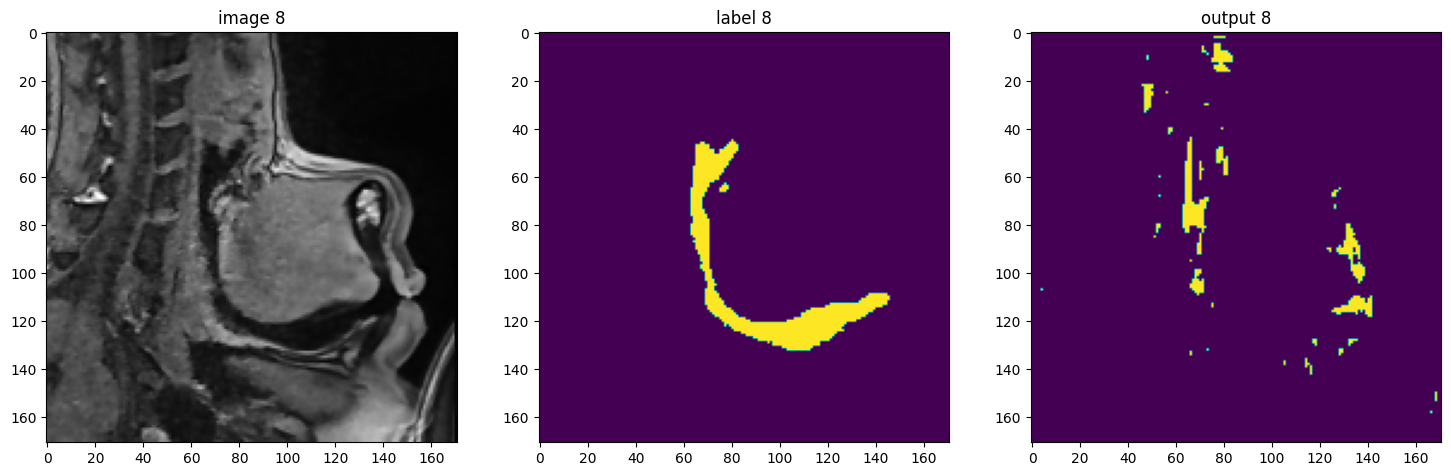

In [16]:


model.load_state_dict(torch.load(
    os.path.join(save_dir, "2d_slice_best_metric_model_1200.pth")))
model.eval()
i = 0
with torch.no_grad():
    for val_data in val_loader:
        val_images = val_data["image"].to(device)
        roi_size = (128, 128)
        sw_batch_size = 2
        slice_inferer = SliceInferer(
            roi_size=roi_size,
            sw_batch_size=sw_batch_size,
            spatial_dim=1,  # Spatial dim to slice along is defined here
            device=torch.device("cpu"),
            padding_mode="replicate",
        )
        val_outputs = slice_inferer(val_images, model).to("cpu")
        # plot the slice [:, :, 80]
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(val_data["image"][0, 0, :, :, 5], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(val_data["label"][0, 0, :, :, 5])
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(torch.argmax(
            val_outputs, dim=1).detach().cpu()[0, :, :, 10])
        plt.savefig(f"./sliceByslice/slicebyslice{i}.png")
        i += 1
        plt.show()


In [ ]:
plt.savefig('slicebyslice.png', dpi=100)